In [1]:
using Distributions, TimeIt, ProgressMeter, PyPlot
include("/home/postdoc/dsen/Desktop/codes/G-ZZ_clean/jl_files/zz_samplers.jl")
include("temp.jl")

run_sampler (generic function with 3 methods)

#### Simulate data:

In [2]:
n_groups, group_size = 10, 200
Nobs = group_size*n_groups
d = 5
dim_total = 1+n_groups+d

σ02 = 1
my_pr = MM_prior(d, n_groups, σ02);

In [3]:
pX = 1e-1
X = spzeros(dim_total, Nobs)
X[1,:] = 1
for group in 1:n_groups
    X[group+1,((group-1)*group_size+1):(group*group_size)] = 1
end
X[n_groups+2:end,:] = sprandn(d, Nobs, pX)
ξ_true = rand(Normal(),dim_total)
y = Float64.([rand(Binomial(1, 1/(1+exp(-ξ_true'X[:,j])))) for j in 1:Nobs])
my_ll = ll_logistic_sp(X,y)
my_model = model(my_ll, my_pr);

### Run GZZ sampler

In [4]:
mb_size = 1
max_attempts = 10^7
prob_het = 0.95
adapt_speed = "none"

lambda = 5e1
start = time()
Print = true
run_sampler(my_model, lambda, max_attempts, mb_size, Print, prob_het, adapt_speed)
print("Time = ", round((time()-start)/60,1), " mins")

10 percent attempts in 2.25 min; zz bounces = 91068, hyp bounces = 4746, total time of process = 94.062 
20 percent attempts in 4.58 min; zz bounces = 181842, hyp bounces = 9521, total time of process = 188.329 
30 percent attempts in 6.97 min; zz bounces = 272436, hyp bounces = 14258, total time of process = 282.266 
40 percent attempts in 9.53 min; zz bounces = 362886, hyp bounces = 19074, total time of process = 376.259 
50 percent attempts in 12.13 min; zz bounces = 453596, hyp bounces = 23866, total time of process = 470.264 
60 percent attempts in 14.75 min; zz bounces = 544093, hyp bounces = 28481, total time of process = 564.369 
70 percent attempts in 17.37 min; zz bounces = 634792, hyp bounces = 33249, total time of process = 658.439 
80 percent attempts in 20.01 min; zz bounces = 725370, hyp bounces = 37877, total time of process = 752.579 
90 percent attempts in 22.61 min; zz bounces = 816175, hyp bounces = 42634, total time of process = 846.802 
100 percent attempts in 25.

### Plot ACFs:

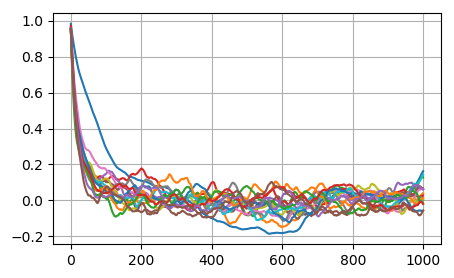

In [5]:
fig = figure("pyplot_barplot",figsize=(5,3))
n_samples = 10^4
maxlag_gzz = 1000
acfs_gzz = zeros(dim_total,maxlag_gzz)
discard = 0
filename = "/xtmp/GZZ_data/mixed_effects/lambda:"*string(lambda)*
        "-dim_cov:"*string(d)*"-n_groups:"*string(n_groups)*
        "-Nobs:"*string(Nobs)*"-mb_size:"*string(mb_size)*".jld"
xt_skel, bt_skel = load(filename, "xt_skeleton", "bt_skeleton")
xi_samples_gzz = extract_samples(xt_skel[:,discard+1:end], 
                             bt_skel[:,discard+1:end], 
                            (bt_skel[end]-bt_skel[discard+1])/n_samples,
                            "linear")[:,1:end-1]
for dim in 1:size(xi_samples_gzz,1)
    a = acf(xi_samples_gzz[dim,:],maxlag_gzz)
    plot(a)
    acfs_gzz[dim,:] = a
end
grid(true)
xt_skel, bt_skel, xi_samples = [], [], []
gc()

### Tune HMC:

In [12]:
ξ0 = randn(dim_total)
Total_time = 6
T = 250
Metropolise = false
Print = false
n_leapfrog_list = 20*(1:5)

20:20:100

In [13]:
for (i,n_leapfrog) in enumerate(reverse(n_leapfrog_list))
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    stepsize = Total_time/n_leapfrog
    xi_samples, hyper_samples, acc = 
    GibbsHMC(my_model, ξ0, stepsize, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
end

HMC acceptance = 100.0 percent; n_leapfrog = 100 in 0.61 mins 


LoadError: [91mArgumentError: Gamma: the condition α > zero(α) && θ > zero(θ) is not satisfied.[39m

In [14]:
Metropolise = true 
Print = false

stepsize = Total_time/90
total_times = 4*stepsize*(6:15)
n_leapfrog_steps = 5*(1:10)

for total_time in total_times
    print("Total time = ", round(total_time,2), "\n")
    for n_leapfrog in n_leapfrog_steps
        start = time()
        prior = MM_prior(d, n_groups, σ02)
        my_ll = ll_logistic_sp(X,y)
        my_model = model(my_ll, prior)
        a, b, c = 
        GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, 500, Metropolise, Print)
        print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
    end
end

Total time = 1.6
HMC acceptance = 0.0 percent; n_leapfrog = 5 in 0.08 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 10 in 0.14 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 15 in 0.2 mins 
HMC acceptance = 75.4 percent; n_leapfrog = 20 in 0.26 mins 
HMC acceptance = 91.0 percent; n_leapfrog = 25 in 0.32 mins 
HMC acceptance = 94.0 percent; n_leapfrog = 30 in 0.38 mins 
HMC acceptance = 92.0 percent; n_leapfrog = 35 in 0.44 mins 
HMC acceptance = 95.6 percent; n_leapfrog = 40 in 0.5 mins 
HMC acceptance = 98.4 percent; n_leapfrog = 45 in 0.56 mins 
HMC acceptance = 97.8 percent; n_leapfrog = 50 in 0.62 mins 
Total time = 1.87
HMC acceptance = 0.0 percent; n_leapfrog = 5 in 0.08 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 10 in 0.14 mins 
HMC acceptance = 0.0 percent; n_leapfrog = 15 in 0.2 mins 
HMC acceptance = 8.4 percent; n_leapfrog = 20 in 0.26 mins 
HMC acceptance = 85.6 percent; n_leapfrog = 25 in 0.32 mins 
HMC acceptance = 91.6 percent; n_leapfrog = 30 in 0.38 mins 
H

In [15]:
total_times_optimal = round.(total_times,2)
n_leapfrog_optimal =  [22,25,29,32,36,39,44,47,50,60];

In [16]:
T = 5000
Metropolise = true
Print = false

for (i,total_time) in enumerate(total_times_optimal) 
    n_leapfrog = n_leapfrog_optimal[i]
    start = time()
    prior = MM_prior(d, n_groups, σ02)
    my_ll = ll_logistic_sp(X,y)
    my_model = model(my_ll, prior)
    xi_samples_hmc, hyper_samples_hmc, acc =
    GibbsHMC(my_model, ξ0, total_time/n_leapfrog, n_leapfrog, T, Metropolise, Print)
    print("n_leapfrog = ", n_leapfrog, " in ", round((time()-start)/60,2), " mins \n")
    filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
    save(filename, "xi_samples", xi_samples_hmc, "hyper_samples", hyper_samples_hmc, "acc", acc)
    xi_samples_hmc, hyper_samples_hmc, acc = [], [], []
    gc()
end

HMC acceptance = 81.96 percent; n_leapfrog = 22 in 2.56 mins 
HMC acceptance = 84.36 percent; n_leapfrog = 25 in 2.87 mins 
HMC acceptance = 82.64 percent; n_leapfrog = 29 in 3.32 mins 
HMC acceptance = 82.7 percent; n_leapfrog = 32 in 3.64 mins 
HMC acceptance = 83.64 percent; n_leapfrog = 36 in 4.1 mins 
HMC acceptance = 84.28 percent; n_leapfrog = 39 in 4.42 mins 
HMC acceptance = 86.12 percent; n_leapfrog = 44 in 4.97 mins 
HMC acceptance = 82.68 percent; n_leapfrog = 47 in 5.31 mins 
HMC acceptance = 84.38 percent; n_leapfrog = 50 in 5.63 mins 
HMC acceptance = 89.82 percent; n_leapfrog = 60 in 6.72 mins 


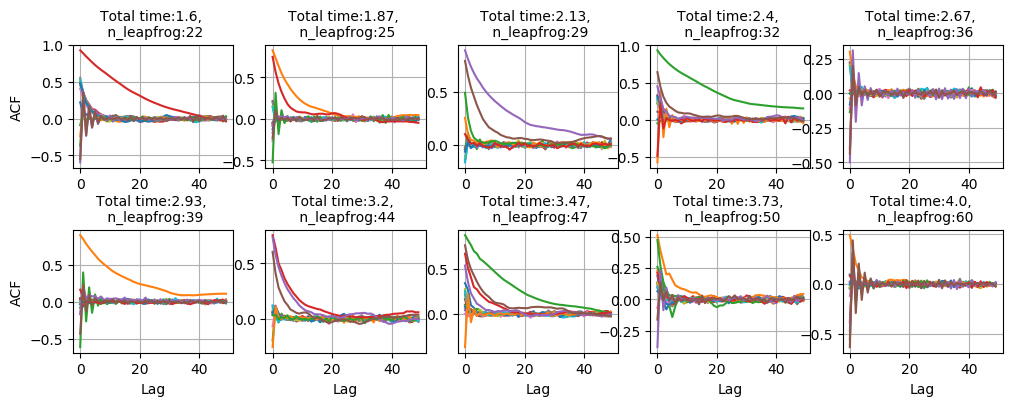

In [17]:
maxlag_hmc = 50
fig = figure(figsize=(12,4))
acfs_hmc = zeros(length(total_times_optimal),dim_total,maxlag_hmc)

for i in 1:2 
    for j in 1:5
        k = 5*(i-1)+j
        total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
        filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
                string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
                "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
        xi_samples_hmc = load(filename, "xi_samples")

        subplot(2,5,k)
        for dim in 1:size(xi_samples_hmc,1) 
            a = acf(xi_samples_hmc[dim,:], maxlag_hmc)
            plot(a)
            acfs_hmc[k,dim,:] = a
        end
        grid(true)  
        title("Total time:"*string(total_time)*", \n n_leapfrog:"*string(n_leapfrog), fontsize=10)
        xi_samples_hmc = []
        gc()
        if i == 2 xlabel("Lag") end
        if j == 1 ylabel("ACF") end
        subplots_adjust(hspace=0.5)
    end
end

In [18]:
T = 5000
maxlag_hmc_list = [40, 30, 50, 50, 5, 50, 25, 45, 20, 5]
hmc_mixing = zeros(length(total_times_optimal))
for i in 1:length(total_times_optimal)
    hmc_mixing[i] = T/maximum(sum(acfs_hmc[i,:,1:maxlag_hmc_list[i]],2))
end
hmc_cost = T*n_leapfrog_optimal*Nobs;

In [19]:
gzz_mixing = n_samples/maximum(sum(acfs_gzz[:,1:300],2))
gzz_cost = max_attempts*mb_size
minimum((gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost))

0.4461034803497914

In [25]:
(gzz_mixing/gzz_cost)./(hmc_mixing./hmc_cost)

10-element Array{Float64,1}:
 2.65365
 7.07754
 2.38659
 1.9262 
 8.68096
 8.50111
 2.69025
 4.16828
 3.57652
 2.66552

In [43]:
k=5
total_time, n_leapfrog = total_times_optimal[k], n_leapfrog_optimal[k]
filename  = "/xtmp/GZZ_data/mixed_effects/GibbsHMC:d:"*
        string(d)*"-n_groups:"*string(n_groups)*"-Nobs:"*string(Nobs)*
        "-total_time:"*string(total_time)*"-n_leapfrog:"*string(n_leapfrog)*".jld"
xi_samples_hmc, hyper_samples_hmc = load(filename, "xi_samples", "hyper_samples");

In [44]:
size(xi_samples_hmc)

(16, 5001)

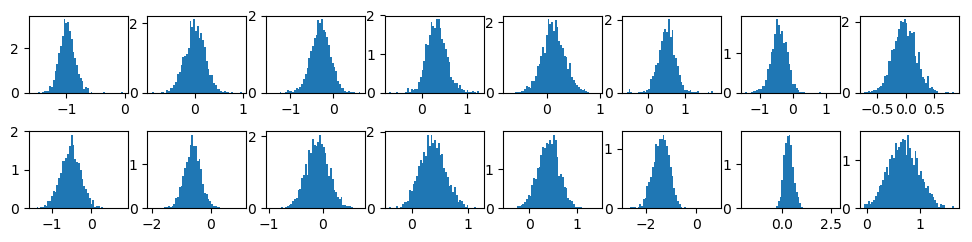

In [48]:
fig = figure(figsize=(12,2.5))
for i in 1:8
    for j in 1:2
        k = (j-1)*8+i
        subplot(2,8,k)
        hist(xi_samples_hmc[k,:], density=true, bins=50)
#         grid(true)
    end
end
subplots_adjust(hspace=0.5)

In [49]:
mean(xi_samples_hmc,2)

16×1 Array{Float64,2}:
 -0.984705  
  0.00396715
 -0.298673  
  0.333913  
  0.124698  
  0.506394  
 -0.415683  
 -0.02293   
 -0.522084  
 -0.620767  
 -0.0989715 
  0.375533  
  0.408167  
 -1.38292   
  0.353295  
  0.695113  

In [51]:
std(xi_samples_hmc,2)

16×1 Array{Float64,2}:
 0.135768
 0.209415
 0.231017
 0.228953
 0.212504
 0.24536 
 0.243652
 0.205863
 0.259145
 0.292029
 0.212147
 0.226505
 0.228325
 0.325404
 0.246505
 0.286129